# robust pca

L'obiettivo di questa lezione è il seguente:

![pca](./images/surveillance3.png)

In [1]:
from glob import glob
import sys, os
import numpy as np
import scipy

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# MAX_ITERS = 10
TOL = 1.0e-8

In [4]:
import re
image_folder = './data/background/'
filelist = [os.path.join(image_folder,file) for file in os.listdir(image_folder) if file.endswith('.png')]
filelist.sort(key=lambda f: int(re.sub('\D', '', f)))

In [5]:
import imageio

In [6]:
from skimage import color
from skimage import io
from skimage.transform import rescale

img = color.rgb2gray(io.imread(filelist[0]))
img = rescale(img, 0.25, anti_aliasing=True)
print(img.shape)
dims = img.shape
img = img.flatten()
img.shape

(34, 60)


(2040,)

In [7]:
def create_data_matrix(filelist):
    return np.vstack([rescale(color.rgb2gray(io.imread(file)),0.25, anti_aliasing=True).flatten()  for file in filelist]).T
    

questa funzione crea una matrice con le immagini caricate, scaliamo le immagini a 60x80 px convertite in scala dei grigi, poi appiattiamo le immagini e otteniamo una colonna di 4800 elementi.

Questa soluzione non è molto leggibile, ma così possiamo caricare un video in una immagine

In [8]:
M = create_data_matrix(filelist)

In [9]:
M.shape

(2040, 5396)

Vediamo come si presenta un fotogramma

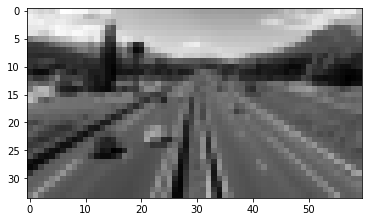

In [10]:
frame = 16
plt.imshow(np.reshape(M[:,frame], dims), cmap='gray')

Creare la matrice con il metodo `create_data_matrix` è abbastanza lento.
Salviamo dunque la matrice in un file. 

In [11]:
np.save("low_res_surveillance_matrix.npy", M)

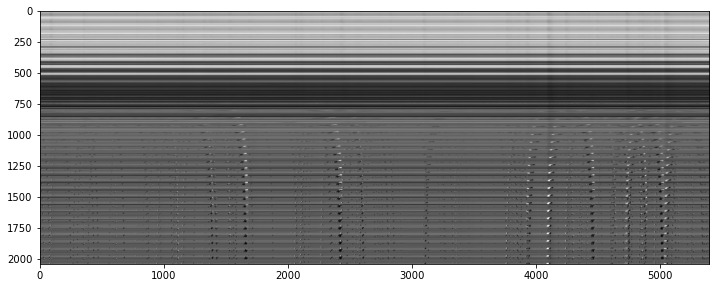

In [12]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

Domanda cosa sono le linee nere che si muovono ?

In [13]:
plt.imsave(fname="image1.jpg", arr=np.reshape(M[:,frame], dims), cmap='gray')

Creiamo una approssimazione della matrice utilizzando il metodo SVD visto in precedenza

In [14]:
from sklearn import decomposition

In [15]:
u, s, v = decomposition.randomized_svd(M, 2)

In [16]:
u.shape, s.shape, v.shape

((2040, 2), (2,), (2, 5396))

ricostruiamo ora la matrice dalla rappresentazione approssimata

In [21]:
low_rank = u @ np.diag(s) @ v

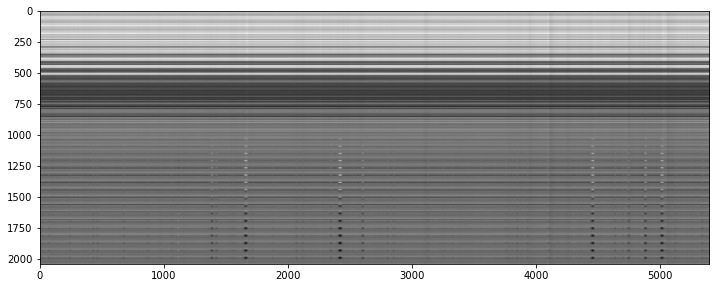

In [18]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

vediamo ora che le linee nere sono sparite

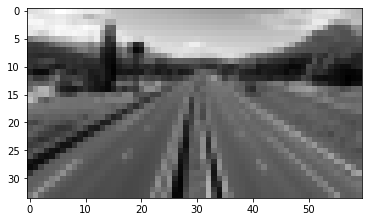

In [19]:
plt.imshow(np.reshape(low_rank[:,frame], dims), cmap='gray');

gli oggetti in movimento sono spariti

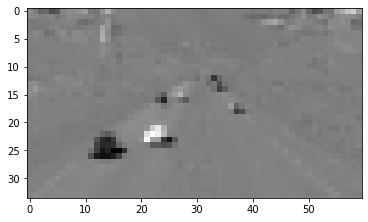

In [20]:
plt.imshow(np.reshape(M[:,frame] - low_rank[:,frame], dims), cmap='gray')

qui abbiamo la maschera degli oggetti in movimento

# Principal Component Analysis (PCA)

Quando lavoriamo con dataset ad alta dimensionalità, spesso facciamo leva sul fatto che i dati hanno una bassa dimensionalità intrinseca, per cercare di mitigare la maledizione della dimensionalità. 

Il metodo [PCA](https://setosa.io/ev/principal-component-analysis/) è utile per eliminare dimensioni. 
Il metodo PCA classico cerca la miglior stima del rango $k$ $L$ di $M$ (Vogliamo minimizzare $\lVert M - L \rVert$ dove $L$ ha rango $k$ )

Truncated SVD ha eseguito proprio questo calcolo!

Abbiamo un problema, il pca tradizionale gestisce molto bene le immagine con piccoli rumori. 
Però è fragile rispetto alle osservazioni gravemente corrotte anche solo una osservazione gravemente corrotta può rovinare la risposta.

Robust PCA fattorizza la matrice in una somma di due matrici, $M = L + S$ con $M$ matrice originale $L$ è la matrice a **basso rango** e $S$ è una matrice **sparsa**.

## Applicazioni della Robust PCA

* Riconoscimento dei visi 
* Videosorveglianza
* Indicizzazione della semantica latente: cattura le parole comuni in tutti i documenti (stop word) mentre cattura le poche parole che distinguono il documento dagli altri (parole chiave)
* Ranking e filtri collaborativi: una piccola porzione delle classifiche disponibili potrebbe essere rumorosa o persino manomessa ([Netflix RAD - Outlier Detection on Big Data on the official netflix blog](https://netflixtechblog.com/rad-outlier-detection-on-big-data-d6b0494371cc))

# la norma L1 induce sparsità

La norma $\lVert x \rVert_{1}=1$ è un diamante gli estremi sono agli angoli 

![norm](./images/L1vsL2.jpg)

[source](https://www.quora.com/Why-is-L1-regularization-supposed-to-lead-to-sparsity-than-L2)

L'algoritmo robust pca può essere scritto come 

$$minimize\; \lVert L \rVert_* + \lambda\lVert S \rVert_1 \\ subject\;to\; L + S = M$$

dove:

* $\lVert \cdot \rVert_1$ rappresenta la [**norma L1**](https://blog.mlreview.com/l1-norm-regularization-and-sparsity-explained-for-dummies-5b0e4be3938a). Minimizzare la norma L1 da come risultato una matrice sparsa. Per una matrice la norma L1 è uguale alla [massima norma assoluta delle colonne](https://math.stackexchange.com/questions/519279/why-is-the-matrix-norm-a-1-maximum-absolute-column-sum-of-the-matrix)

* 